In [32]:
import numpy as np
import pyvista as pv
import os
from scipy import interpolate
import matplotlib.pyplot as plt

In [33]:
def compute_errors_helper(s1, s2):
    # Distance between each point in streamline
    dv_1 = s1[1:,:] - s1[:-1,:]
    dv_2 = s2[1:,:] - s2[:-1,:]

    # Length / Magnitude of each delta t
    dl_1 = np.sqrt(np.sum(dv_1**2, axis=1))
    dl_2 = np.sqrt(np.sum(dv_2**2, axis=1))

    t1 = np.r_[0, np.cumsum(dl_1)]
    t2 = np.r_[0, np.cumsum(dl_2)]

    # Lengths of streamline
    length_1 = t1[-1]
    length_2 = t2[-1]

    x1 = interpolate.interp1d(t1, s1[:,0])
    y1 = interpolate.interp1d(t1, s1[:,1])
    z1 = interpolate.interp1d(t1, s1[:,2])
    p1 = lambda t : np.c_[x1(t), y1(t), z1(t)]

    x2 = interpolate.interp1d(t2, s2[:,0])
    y2 = interpolate.interp1d(t2, s2[:,1])
    z2 = interpolate.interp1d(t2, s2[:,2])
    p2 = lambda t : np.c_[x2(t), y2(t), z2(t)]

    t = np.linspace(0, min(length_1, length_2), 11)    
    ind_error = np.linalg.norm(p1(t) - p2(t), axis=1) # Same as magnitude
    tot_error = np.sum(ind_error)
    rms_error = np.sqrt(np.mean(ind_error**2))
    
    return t, ind_error, tot_error, rms_error
    

In [34]:
def compute_errors(streams_base, streams_sampled):
    '''
        t = [lengths of each streamline]
        ind_errors = [streamline[error compared to base]]
        tot_error = [total error of each streamline]
        rms_error = [total rms error of each streamline]
    '''
    ind_errors = []
    tot_errors = []
    rms_errors = []
    
    streams_1 = streams_base.copy()
    streams_2 = streams_sampled.copy()
    
    for i in range(streams_2.n_cells):          
        stream_2 = streams_2.cell_points(i)
        for j in range(streams_1.n_cells):   
            stream_1 = streams_1.cell_points(j)
        
            if(stream_1[0][0] == stream_2[0][0]):
                streams_1 = streams_1.remove_cells(j)  
                t, ind_error, tot_error, rms_error = compute_errors_helper(stream_1, stream_2)
                ind_errors.append(ind_error)
                tot_errors.append(tot_error)
                rms_errors.append(rms_error)
                break
    
    return t, ind_errors, tot_errors, rms_errors

In [35]:
def create_base_streamlines(mesh):
    w,v,u = mesh.point_data['w'], mesh.point_data['v'], mesh.point_data['u']

    vectors = np.empty((mesh.n_points, 3))
    vectors[:,0] = u
    vectors[:,1] = v
    vectors[:,2] = w

    mesh['vectors'] = vectors

    streamlines, seed_pts = mesh.streamlines(
        'vectors', 
        return_source=True,
        n_points=100,
        source_radius=1.5,
        source_center=(6.0,0,0), 
        # pointa=(-0.5, -1.5, -0.5),
        # pointb=(-0.5, 1.5, 0.5)
    )
    
    return streamlines, seed_pts

In [36]:
def compute_downsampled_streamlines(s, seeds, base_mesh):
    '''
        Computes streamlines from seed points and down sample size
    '''
    w,v,u = base_mesh.point_data['w'], base_mesh.point_data['v'], base_mesh.point_data['u']

    u.shape = v.shape = w.shape = base_mesh.dimensions


    # Down Sample / Decimate
    u = u[::s, ::s, ::s] 
    v = v[::s, ::s, ::s]
    w = w[::s, ::s, ::s]

    dims = u.shape

    u = u.flatten()
    v = v.flatten()
    w = w.flatten()

    vectors = np.empty((int(len(u)), 3))
    vectors[:,0] = u
    vectors[:,1] = v
    vectors[:,2] = w

    mesh = pv.UniformGrid(
        dims=dims,
        spacing=tuple([x*s for x in list(base_mesh.spacing)]),
        origin=base_mesh.origin
    )

    mesh['vectors'] = vectors
    
    streamlines = mesh.streamlines_from_source(
        vectors='vectors', 
        source=seeds
    )
    
    return streamlines, mesh

In [37]:
def entry_point(filename):
    mesh = pv.read(filename)
    streamlines, seed_pts = create_base_streamlines(mesh)
    streamlines2, mesh2 = compute_downsampled_streamlines(2, seed_pts, mesh)
    streamlines4, mesh4 = compute_downsampled_streamlines(4, seed_pts, mesh)
    streamlines8, mesh8 = compute_downsampled_streamlines(8, seed_pts, mesh)
    streamlines16, mesh16 = compute_downsampled_streamlines(16, seed_pts, mesh)
    streamlines32, mesh32 = compute_downsampled_streamlines(32, seed_pts, mesh)
    streamlines64, mesh64 = compute_downsampled_streamlines(64, seed_pts, mesh)
    return streamlines, streamlines2, streamlines4, streamlines8, streamlines16, streamlines32, streamlines64

In [38]:
reynolds160 = '.\\Data\\Structured160\\halfcylinder-0.00.vti'
reynolds640 = '.\\Data\\Structured640\\halfcylinder-0.00.vti'
s, s2, s4, s8, s16, s32, s64 = entry_point(reynolds160)
k, k2, k4, k8, k16, k32, k64 = entry_point(reynolds640)

In [39]:
t2, ind_errors2, tot_errors2, rms_errors2 = compute_errors(s, s2)
t4, ind_errors4, tot_errors4, rms_errors4 = compute_errors(s, s4)
t8, ind_errors8, tot_errors8, rms_errors8 = compute_errors(s, s8)
t16, ind_errors16, tot_errors16, rms_errors16 = compute_errors(s, s16)
t32, ind_errors32, tot_errors32, rms_errors32 = compute_errors(s, s32)
t64, ind_errors64, tot_errors64, rms_errors64 = compute_errors(s, s64)

In [40]:
l2, lind_errors2, ltot_errors2, lrms_errors2 = compute_errors(k, k2)
l4, lind_errors4, ltot_errors4, lrms_errors4 = compute_errors(k, k4)
l8, lind_errors8, ltot_errors8, lrms_errors8 = compute_errors(k, k8)
l16, lind_errors16, ltot_errors16, lrms_errors16 = compute_errors(k, k16)
l32, lind_errors32, ltot_errors32, lrms_errors32 = compute_errors(k, k32)
l64, lind_errors64, ltot_errors64, lrms_errors64 = compute_errors(k, k64)

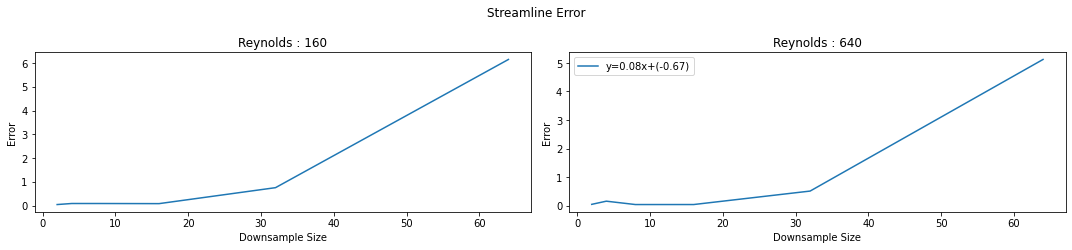

In [46]:
# Plot of average error over sample size
a2 = np.average(tot_errors2)
a4 = np.average(tot_errors4)
a8 = np.average(tot_errors8)
a16 = np.average(tot_errors16)
a32 = np.average(tot_errors32)
a64 = np.average(tot_errors64)

b2 = np.average(ltot_errors2)
b4 = np.average(ltot_errors4)
b8 = np.average(ltot_errors8)
b16 = np.average(ltot_errors16)
b32 = np.average(ltot_errors32)
b64 = np.average(ltot_errors64)

x = [2, 4, 8, 16, 32, 64]
y1 = [a2, a4, a8, a16, a32, a64]
y2 = [b2, b4, b8, b16, b32, b64]

slope1, intercept1 = np.polyfit(x, y1, 1)
slope2, intercept2 = np.polyfit(x, y2, 1)

fig, axs = plt.subplots(1,2, figsize=(15, 3.5))

fig.suptitle(f'Streamline Error')
axs[0].set_title(f'Reynolds : 160')
axs[1].set_title(f'Reynolds : 640')
axs[0].set(xlabel='Downsample Size', ylabel='Error')
axs[1].set(xlabel='Downsample Size', ylabel='Error')
axs[0].plot(x, y1, label=f'y={round(slope1,2)}x+({round(intercept1,2)})')
axs[1].plot(x, y2, label=f'y={round(slope2,2)}x+({round(intercept2,2)})')           
fig.tight_layout()
plt.legend()
plt.show()

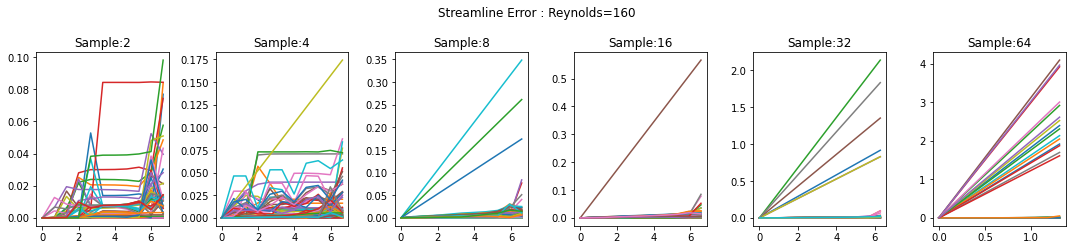

In [45]:
# Plot of each streamlines error as it grows in comparison to the base

figi, axsi = plt.subplots(1,6, figsize=(15, 3.5))
figi.suptitle(f'Streamline Error : Reynolds=160')

for idx, g in enumerate(axsi):
    g.set_title(f'Sample:{2**(idx+1)}')

for i in range(len(ind_errors2)):
    axsi[0].plot(t2, ind_errors2[i], label="error {i}")
    
for i in range(len(ind_errors4)):
    axsi[1].plot(t4, ind_errors4[i], label="error {i}")
    
for i in range(len(ind_errors8)):
    axsi[2].plot(t8, ind_errors8[i], label="error {i}")
    
for i in range(len(ind_errors16)):
    axsi[3].plot(t16, ind_errors16[i], label="error {i}")   
    
for i in range(len(ind_errors32)):
    axsi[4].plot(t32, ind_errors32[i], label="error {i}") 
    
for i in range(len(ind_errors64)):
    axsi[5].plot(t64, ind_errors64[i], label="error {i}")     
    
figi.tight_layout()
plt.show()

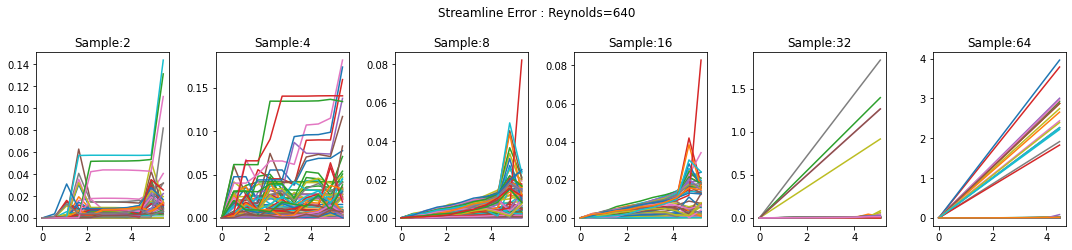

In [44]:
# Plot of each streamlines error as it grows in comparison to the base

figk, axsk = plt.subplots(1,6, figsize=(15, 3.5))
figk.suptitle(f'Streamline Error : Reynolds=640')

for idx, g in enumerate(axsk):
    g.set_title(f'Sample:{2**(idx+1)}')

for i in range(len(lind_errors2)):
    axsk[0].plot(l2, lind_errors2[i], label="error {i}")
    
for i in range(len(lind_errors4)):
    axsk[1].plot(l4, lind_errors4[i], label="error {i}")
    
for i in range(len(lind_errors8)):
    axsk[2].plot(l8, lind_errors8[i], label="error {i}")
    
for i in range(len(lind_errors16)):
    axsk[3].plot(l16, lind_errors16[i], label="error {i}")   
    
for i in range(len(lind_errors32)):
    axsk[4].plot(l32, lind_errors32[i], label="error {i}") 
    
for i in range(len(lind_errors64)):
    axsk[5].plot(l64, lind_errors64[i], label="error {i}")     
    
figk.tight_layout()
plt.show()